<a href="https://colab.research.google.com/github/naseembabu/GAN/blob/main/DCGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3 MB 11 kB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 3.8 MB 54.7 MB/s 
     |████████████████████████████████| 503 kB 79.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=a9e3a0a738f7ff3f1ff92450d2972fef7174d0d12fab0f81b2247fe5811205ad
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

In [3]:

# Training Params
num_steps = 10000
batch_size = 128
lr_generator = 0.002
lr_discriminator = 0.002

# Network Params
image_dim = 784 # 28*28 pixels * 1 channel
noise_dim = 100 # Noise data points

In [4]:
# Build Networks
# Network Inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
# A boolean to indicate batch normalization if it is training or inference time
is_training = tf.placeholder(tf.bool)

#LeakyReLU activation
def leakyrelu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # TensorFlow Layers automatically create variables and calculate their
        # shape, based on the input.
        x = tf.layers.dense(x, units=7 * 7 * 128)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        # Deconvolution, image shape: (batch, 14, 14, 64)
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        # Deconvolution, image shape: (batch, 28, 28, 1)
        x = tf.layers.conv2d_transpose(x, 1, 5, strides=2, padding='same')
        # Apply tanh for better stability - clip values to [-1, 1].
        x = tf.nn.tanh(x)
        return x


# Discriminator Network
# Input: Image, Output: Prediction Real/Fake Image
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Typical convolutional neural network to classify images.
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Flatten
        x = tf.reshape(x, shape=[-1, 7*7*128])
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Output 2 classes: Real and Fake images
        x = tf.layers.dense(x, 2)
    return x

# Build Generator Network
gen_sample = generator(noise_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse=True)

# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# Build Loss (Labels for real images: 1, for fake images: 0)
# Discriminator Loss for real and fake samples
disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
# Sum both loss
disc_loss = disc_loss_real + disc_loss_fake
# Generator Loss (The generator tries to fool the discriminator, thus labels are 1)
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
# TensorFlow UPDATE_OPS collection holds all batch norm operation to update the moving mean/stddev
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
# `control_dependencies` ensure that the `gen_update_ops` will be run before the `minimize` op (backprop)
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


In [5]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)
    
# Training
for i in range(1, num_steps+1):

    # Prepare Input Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # Rescale to [-1, 1], the input range of the discriminator
    batch_x = batch_x * 2. - 1.

    # Discriminator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
    # Generator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, is_training:True})
    
    if i % 500 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 3.740492, Discriminator Loss: 1.905504
Step 500: Generator Loss: 1.350221, Discriminator Loss: 1.036241
Step 1000: Generator Loss: 2.302377, Discriminator Loss: 0.621448
Step 1500: Generator Loss: 2.251809, Discriminator Loss: 0.761191
Step 2000: Generator Loss: 2.324379, Discriminator Loss: 0.795671
Step 2500: Generator Loss: 3.080086, Discriminator Loss: 0.373773
Step 3000: Generator Loss: 3.983905, Discriminator Loss: 0.504125
Step 3500: Generator Loss: 3.745538, Discriminator Loss: 0.286884
Step 4000: Generator Loss: 3.774120, Discriminator Loss: 0.274741
Step 4500: Generator Loss: 4.859711, Discriminator Loss: 0.158320
Step 5000: Generator Loss: 4.717277, Discriminator Loss: 0.346601
Step 5500: Generator Loss: 4.986274, Discriminator Loss: 0.126868
Step 6000: Generator Loss: 2.598251, Discriminator Loss: 0.830805
Step 6500: Generator Loss: 3.540011, Discriminator Loss: 0.131315
Step 7000: Generator Loss: 7.028179, Discriminator Loss: 0.341826
Step 7500: Gen

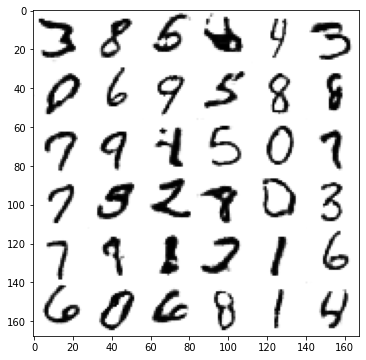

In [6]:
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={noise_input: z, is_training:False})
    # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
    g = (g + 1.) / 2.
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()